In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

# Load data

In [3]:
path = "Data/"
sample_submission = pd.read_csv(path + "sample_submission.csv")
app_events = pd.read_csv(path + "app_events.csv")
app_labels = pd.read_csv(path + "app_labels.csv")
events = pd.read_csv(path + "events.csv")
gender_age_test = pd.read_csv(path + "gender_age_test.csv")
gender_age_train = pd.read_csv(path + "gender_age_train.csv")
phone_brand_device_model = pd.read_csv(path + "phone_brand_device_model.csv")

# Feature engineering

In [4]:
data_sets = [sample_submission, app_events, app_labels, events, gender_age_test, gender_age_train, phone_brand_device_model]

for data in data_sets:
    print(data.shape)

(112071, 13)
(32473067, 4)
(459943, 2)
(3252950, 5)
(112071, 1)
(74645, 4)
(187245, 3)


Our goal is to find the probability for each gender and age-range as shown below in sample submission.

In [63]:
sample_submission.head(5)

,device_id,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
0,1002079943728939269,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
1,-1547860181818787117,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
2,7374582448058474277,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
3,-6220210354783429585,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
4,-5893464122623104785,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833


In [20]:
app_events.head(5)

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [21]:
app_events.describe()

,event_id,app_id,is_installed,is_active
count,3.247307e+07,3.247307e+07,32473067.0,3.247307e+07
mean,1.625564e+06,1.182779e+18,1.0,3.921094e-01
std,9.384682e+05,5.360173e+18,0.0,4.882209e-01
min,2.000000e+00,-9.221157e+18,1.0,0.000000e+00
25%,8.134720e+05,-3.474568e+18,1.0,0.000000e+00
50%,1.626907e+06,1.387044e+18,1.0,0.000000e+00
75%,2.441106e+06,6.043001e+18,1.0,1.000000e+00
max,3.252948e+06,9.222488e+18,1.0,1.000000e+00


In [23]:
app_labels.head(5)

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [24]:
app_labels.describe()

,app_id,label_id
count,4.599430e+05,459943.000000
mean,1.912461e+17,664.849749
std,5.269442e+18,192.797736
min,-9.223281e+18,2.000000
25%,-4.305882e+18,548.000000
50%,1.083204e+17,714.000000
75%,4.830475e+18,795.000000
max,9.223318e+18,1021.000000


In [25]:
events.head(5)

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [7]:
import folium
from folium import plugins

m = folium.Map([31.24, 121.3], zoom_start=2)

for index, row in events.head(5000).iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=4,
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)

arr = events.head(5000)[['latitude', 'longitude']].as_matrix()

# plot heatmap
m.add_child(plugins.HeatMap(arr, radius=4))
m

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [29]:
gender_age_test.head(5)

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


In [30]:
gender_age_train.head(5)

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


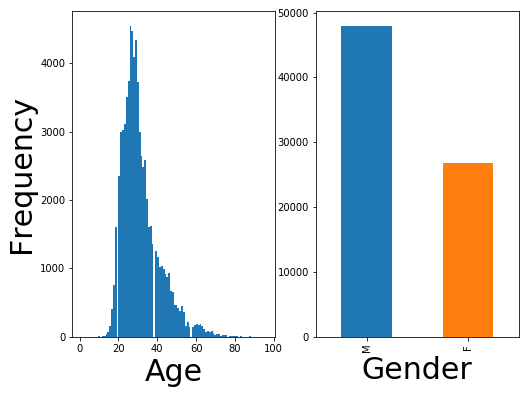

In [64]:
fig, axs = plt.subplots(1, 2, figsize = (8, 6))

axs[0].set_xlabel('Age', fontsize=30)
axs[0].set_ylabel('Frequency', fontsize=30)
axs[0].hist(gender_age_train.age, 100)

axs[1].set_xlabel('Gender', fontsize=30)
gender_age_train.gender.value_counts().plot(kind='bar');

In [46]:
phone_brand_device_model.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [70]:
phone_brand_device_model.phone_brand.value_counts().head(20)

小米      43210
三星      34286
华为      32564
vivo    14395
OPPO    14289
魅族      11853
酷派       8407
联想       6761
金立       2768
HTC      2682
中兴       2096
乐视       1930
索尼       1821
努比亚      1144
LG        763
中国移动      671
TCL       586
朵唯        544
锤子        535
优米        492
Name: phone_brand, dtype: int64